# Classify coherent structures of Rayleigh-Benard convection

This notebook uses SIFT feature vectors to generate a distance matrix between defects in Rayleigh-Benard Convection. Rather than matching defect types, the quality of the matching is used to formulate a distance, and this distance matrix is then used to map the point cloud of defects to Euclidean space using diffusion maps and LLE. A Gaussian mixture model is then used to cluster the point cloud of defects. The info for the Hough transform voting is from http://conf-scoop.org/IWIP-2014/4.V.Seib_IWIP.pdf

In [300]:
import numpy as np
import scipy
from scipy.cluster import hierarchy as hc
import pandas as pd
from skimage import morphology
from scipy import misc
from matplotlib import pyplot as plt
import math, time
from skimage import measure
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy import spatial
from scipy.cluster.hierarchy import dendrogram, linkage


%matplotlib inline  

## Set up local environment variables

In [102]:
sDir = '/Users/birdbrain/Documents/Research/Projects/Schatz/Data/g21chaotic/r4000_2016_11_01_superfast/g21flow'
centerx = 210 # Center-x of circular crop
centery = 210 # Center-y of circular crop
roll_width = 30 # Width of a single roll
crop_radius = 210-roll_width # Radius of circular crop
sFeatureVectors = 'feature_vectors_2/%06d.txt'
sBmp = 'bmps/%06d.bmp'
keypoint_orientation_bins = 16

## Set up variables for local defect computations

In [103]:
radius = roll_width

## Utility functions

In [104]:
def loadData(idx):
    
    # Get feature vectors
    fv = pd.read_csv(sDir + "/" + (sFeatureVectors % idx), sep=' ')
    fv = fv.astype(np.int16)
    
    # Get bitmap image
    bmp = misc.imread(sDir + "/" + sBmp % idx)

    return (fv, bmp)


In [306]:
def computeDistance(location1, fv1, location2, fv2, _radius, _location_bins, _rotation_bins, _makeplots):
    """Compute the distance between two patterns based on their keypoint features.
    Based on using Hough transform voting to find clusters of matches which align with the same
    relative orientation to the center of the pattern.

    Arguments:
    location1 -- the (x,y) location of the first pattern center
    fv1 -- The feature vector (with index, (x,y) location, type vector, and orientation) for the first pattern
    location2 -- the (x,y) location of the second pattern center
    fv2 -- The feature vector (with index, (x,y) location, type vector, and orientation) for the second pattern
    """
    
    boxradius = _radius # For Hough transform
    
    ht_vectors = []
    ht_accumulator = []
    
    feature_index = 11
    
    x1 = int(location1[0])
    y1 = int(location1[1])
    time1 = int(fv1[0,0])
    
    x2 = int(location2[0])
    y2 = int(location2[1])
    time2 = int(fv2[0,0])
    
    if _makeplots:
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
        plt.subplot(1,2,1)
        bmp1 = bmps[time1][(y1-boxradius):(y1+boxradius), (x1-boxradius):(x1+boxradius)]
        plt.imshow(bmp1)
        plt.scatter(fv1[:,1] - x1 + boxradius, fv1[:,2] - y1 + boxradius, color='white', edgecolor='black')
        
        plt.subplot(1,2,2)
        bmp2 = bmps[time2][(y2-boxradius):(y2+boxradius), (x2-boxradius):(x2+boxradius)]
        plt.imshow(bmp2)
        plt.scatter(fv2[:,1] - x2 + boxradius, fv2[:,2] - y2 + boxradius, color='white', edgecolor='black')
        plt.show()
    
        plt.rcParams['figure.figsize'] = (15.0, 3.0)
    
    _dist = 300
    
    
    # Match on the local keypoint descriptor
    # Loop through the features in the second feature vector
    for i in range(fv1.shape[0]):
        
        if _makeplots:
            print "Feature #%d" % i
        
        # Only keypoints with same type should be matched
        keypoint_type = np.argwhere(fv1[i,3:9]==1)
        fv2_sametype = fv2[np.where(fv2[:,keypoint_type+3]==1)[0], :]
        
        # If there's at least one keypoint with the same type:
        if len(fv2_sametype)>0:
            
            allfv = np.vstack((fv1[i,:], fv2_sametype))
            allfv = allfv[:,feature_index:]

            # Get the nearest neighbors
            num_neighbors = 5
            distmat = spatial.distance.pdist(allfv)
            distmat = spatial.distance.squareform(distmat)
            sorted_distances = sorted((e,i) for i,e in enumerate(distmat[0,1:]))
            sorted_distances = np.asarray(sorted_distances)
            nn = sorted_distances[0:5, :]

            
            if _makeplots:
                print nn.T
                bmp0 = bmps[time1][(fv1[i,2] - boxradius):(fv1[i,2] + boxradius), (fv1[i,1] - boxradius):(fv1[i,1] + boxradius)]
                plt.subplot(1,num_neighbors+1,1)
                plt.imshow(bmp0);
                plt.scatter(boxradius, boxradius, color='white', edgecolor='black');
            
            for n in range(min(num_neighbors, len(nn[:,0]))):
                matched_nn = fv2_sametype[nn[n,1],:]
                
                if _makeplots:
                    bmp_match = bmps[time2][(matched_nn[2] - boxradius):(matched_nn[2] + boxradius), (matched_nn[1] - boxradius):(matched_nn[1] + boxradius)]

                    plt.subplot(1,num_neighbors+1,n+2)
                    plt.imshow(bmp_match);
                    plt.scatter(boxradius, boxradius, color='white', edgecolor='black');

            if _makeplots:
                plt.show();
                
            # Do the Hough transform stuff
            # Get the nearest neighbor
            nn = nn[0,:]
            matched_nn = fv2_sametype[nn[1],:]
            
            # Get the translation vector from the original image
            v_prime = [x1, y1] - fv1[i,1:3]
            
            # Rotate by the orientations
            alpha = math.radians(abs(fv1[i,9] - matched_nn[9])*(180./keypoint_orientation_bins))
            v = np.dot(np.asarray([[math.cos(alpha), -math.sin(alpha)], [math.sin(alpha), math.cos(alpha)]]), v_prime)
            
            # Compute the estimated centroid of the matched image
            c_s = v + matched_nn[1:3]
            
            # Center it at zero
            c_s_centered = c_s - np.asarray([x1, y1])
            
            # Bin the centroid values
            c_accum = np.floor(c_s_centered*(float(_location_bins)/float(_radius)))
            c_accum_p1 = c_accum + 1
            
            # Get the orientation vote
            i_r_prime = (alpha + math.pi)*_rotation_bins*(1./(2.*math.pi))
            
            # Bin it
            r_accum = math.floor(i_r_prime) % _rotation_bins
            r_accum_p1 = math.floor(i_r_prime+1) % _rotation_bins
            
            # Make a vector out of it
            accum = np.hstack(( [i], c_accum, c_accum_p1, [r_accum], [r_accum_p1], [nn[0]]))
            
            # Add it to the hough transform vector
            if len(ht_vectors) == 0:
                ht_vectors = accum
                
            else:
                ht_vectors = np.vstack((ht_vectors, accum))
                        
            # Add it to the hough transform accumulator
            for _x in [1,3]:
                for _y in [2,4]:
                    for _r in [5,6]:
                        if len(ht_accumulator) == 0:
                            ht_accumulator = np.asarray([accum[0], accum[_x], accum[_y], accum[_r], accum[7]])
                        else:
                            ht_accumulator = np.vstack((ht_accumulator, np.asarray([accum[0], accum[_x], accum[_y], accum[_r], accum[7]])))
                
    if len(ht_accumulator) > 0:
        
        # Get the bin with the highest vote
        tmp_accumulator = ht_accumulator[:,1:4]
        b = np.ascontiguousarray(tmp_accumulator).view(np.dtype((np.void, tmp_accumulator.dtype.itemsize * tmp_accumulator.shape[1])))
        _, idx, counts = np.unique(b, return_index=True, return_counts=True)
        top_ht = np.argsort(counts)

        sorted_accumulator = np.concatenate((tmp_accumulator[idx[top_ht]][::-1], np.reshape(counts[top_ht][::-1].T, (len(counts),1))), axis=1)
        highest_bin = sorted_accumulator[0,0:(sorted_accumulator.shape[1]-1)]

        # Get all the bins that are within one sup-norm distance away
        subtract_bin = np.matlib.repmat(highest_bin, tmp_accumulator.shape[0], 1)
        differences = np.abs(tmp_accumulator - subtract_bin)
        close_bins = ht_accumulator[np.argwhere(np.max(differences, axis=1)<=1),:]

        # Get the records corresponding to those bin values
        matching_records = np.reshape(close_bins, (close_bins.shape[0], close_bins.shape[2]))
        matching_records = matching_records[:,[0, -1]]
        tmp_matching_records = np.ascontiguousarray(matching_records).view(np.dtype((np.void, matching_records.dtype.itemsize * matching_records.shape[1])))
        _, idx = np.unique(tmp_matching_records, return_index=True)

        # Get the corresponding features and take the average distance
        matched_features = matching_records[idx, :]

        if _makeplots:
            print matched_features
            
        _dist = np.average(matched_features[:,1])
    
    return _dist

## Compute the distances between patterns from two nearby images

In [278]:
t1 = 1000
t2 = 1015

bmps = {}
features = []

for idx in [t1, t2]:

    fv, bmp = loadData(idx)
    
    # Add bitmap image to dictionary, where idx is the key and the bitmap is the value
    bmps[idx] = bmp
    
    if len(features) == 0:
        features = fv
    else:
        features = np.vstack([features, fv])

features = features.astype(np.int16)

features1 = features[(features[:,0] == t1)]
features2 = features[(features[:,0] == t2)]
print features1.shape, features2.shape

(126, 252) (147, 252)


In [279]:
for i in range(features1.shape[0]):

    location1 = np.asarray(features1[i,1:3])
    location2 = np.asarray(features1[i,1:3])

    # Get the features that are within the radius of the locations
    k1 = spatial.KDTree(features1[:, 1:3])
    k2 = spatial.KDTree(features2[:, 1:3])

    # Get 50 nearest neighbors within radius
    nn1 = k1.query(location1, k=50, distance_upper_bound=radius)
    nn2 = k2.query(location2, k=50, distance_upper_bound=radius)

    # Remove infinite matches
    nn1 = nn1[1]
    nn1 = nn1[(nn1<features1.shape[0])]
    nn2 = nn2[1]
    nn2 = nn2[(nn2<features2.shape[0])]

    f1 = features1[nn1]
    f2 = features2[nn2]

    dist = computeDistance(location1, f1, location2, f2, radius, 10, 8, 0)

    print i, dist, f1.shape[0]

0 12.5606562566 7
1 32.023431853 5
2 24.6850089585 10
3 15.1585621229 8
4 26.4296886967 12
5 17.6639861404 3
6 32.023431853 5
7 37.1861907235 4
8 18.4497474683 9
9 19.1054300754 8
10 31.1506802145 8
11 17.4460738023 6
12 8.4593003944 9
13 23.1236499447 13
14 24.6850089585 10
15 20.1128619362 7
16 21.8100600573 13
17 25.3020623126 5
18 26.1177276566 9
19 17.4460738023 6
20 13.9767208558 8
21 22.765547852 13
22 24.6850089585 10
23 170.560839585 2
24 19.7638177036 8
25 23.3487877041 13
26 16.5796362876 6
27 27.8121512403 10
28 18.0189799618 9
29 12.2065556157 1
30 8.53575188797 4
31 7.93567829439 2
32 9.2528279812 3
33 9.10468449536 4
34 17.4257778466 4
35 24.4367112633 4
36 27.7833147643 12
37 29.4086406718 4
38 25.5341652925 9
39 49.0830548294 13
40 23.7742980061 10
41 24.2987627063 10
42 23.9832399158 10
43 24.2987627063 10
44 6.0827625303 1
45 23.3487877041 13
46 27.8121512403 11
47 58.2249307737 13
48 22.8921429977 13
49 22.7343354105 11
50 22.7042271998 12
51 19.0441939961 8
52 12.4

/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


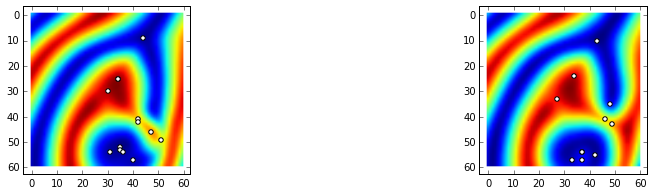

Feature #0
[[  35.0142828    63.03967005  222.77567192]
 [   0.            1.            2.        ]]


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


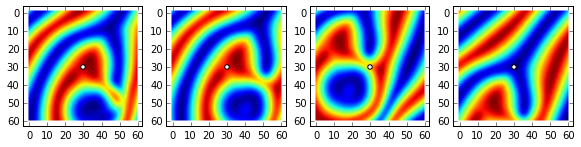

Feature #1
[[  25.63201124  203.66393888  206.17468322  206.30559857  214.0747533 ]
 [   0.            1.            3.            2.            4.        ]]


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


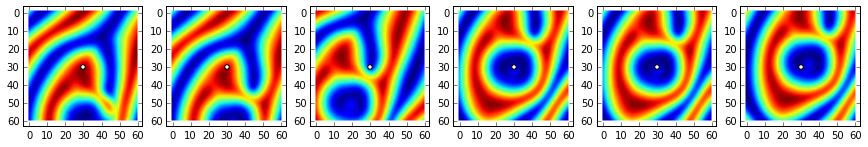

Feature #2
[[  41.26742056  203.42320418  205.630737    205.89803302  214.11212016]
 [   0.            1.            3.            2.            4.        ]]


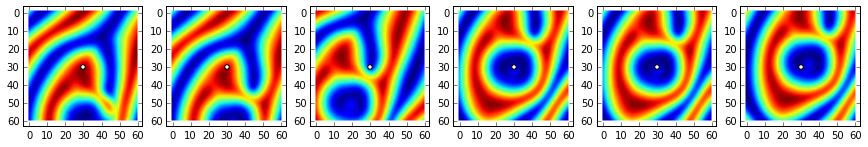

Feature #3
[[ 28.53068524]
 [  0.        ]]


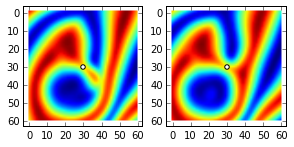

Feature #4
[[ 27.]
 [  0.]]


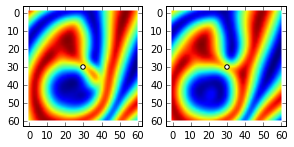

Feature #5
[[ 23.68543856  38.39270764]
 [  0.           1.        ]]


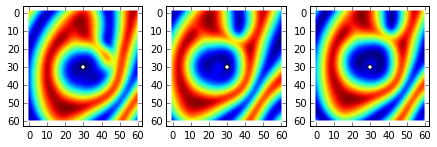

Feature #6
[[ 150.99337734  173.41856879]
 [   1.            0.        ]]


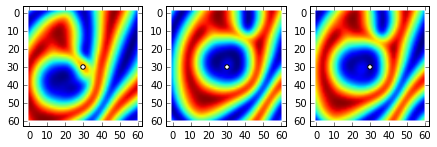

Feature #7
[[  24.55605832   30.90307428   30.96772513   41.37632173  222.60727751]
 [   4.            2.            3.            1.            0.        ]]


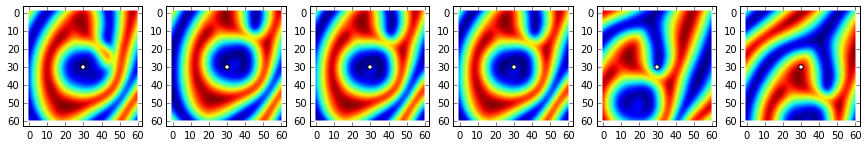

Feature #8
[[  24.4744765    27.98213716   28.89636655   39.54743987  218.45823399]
 [   4.            3.            2.            1.            0.        ]]


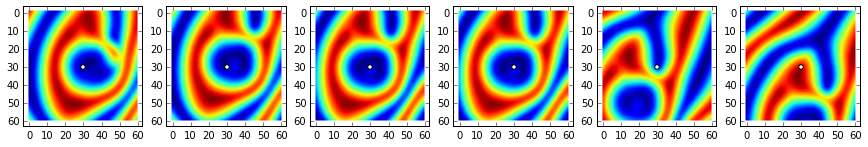

Feature #9
[[  29.20616373  170.45820602  212.25927542]
 [   2.            1.            0.        ]]


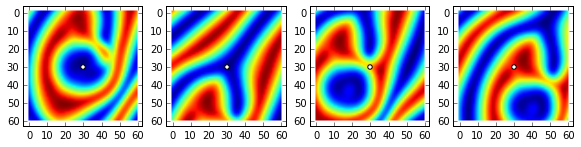

Feature #10
[[   9.21954446  172.92194771  213.69604582]
 [   2.            1.            0.        ]]


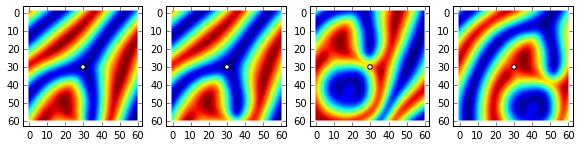

Feature #11
[[ 43.84062043]
 [  0.        ]]


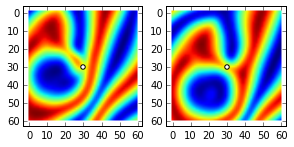

Feature #12
[[  27.65863337   28.61817604   28.93095228   38.78143886  214.28485714]
 [   2.            4.            3.            1.            0.        ]]


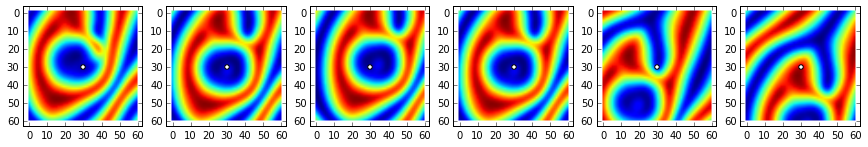

[[   0.           35.0142828 ]
 [   6.          150.99337734]
 [   7.           24.55605832]
 [  10.            9.21954446]
 [   1.           25.63201124]]


In [277]:
i = 39

location1 = np.asarray(features1[i,1:3])
location2 = np.asarray(features1[i,1:3])

# Get the features that are within the radius of the locations
k1 = spatial.KDTree(features1[:, 1:3])
k2 = spatial.KDTree(features2[:, 1:3])

# Get 50 nearest neighbors within radius
nn1 = k1.query(location1, k=50, distance_upper_bound=radius)
nn2 = k2.query(location2, k=50, distance_upper_bound=radius)

# Remove infinite matches
nn1 = nn1[1]
nn1 = nn1[(nn1<features1.shape[0])]
nn2 = nn2[1]
nn2 = nn2[(nn2<features2.shape[0])]

f1 = features1[nn1]
f2 = features2[nn2]

dist = computeDistance(location1, f1, location2, f2, radius, 10, 8, 1)


# Compute the distance matrix for a collection of patterns

In [376]:
t1 = 1000
t2 = 1005

bmps = {}
features = []

for idx in [t1, t2]:

    fv, bmp = loadData(idx)
    
    # Add bitmap image to dictionary, where idx is the key and the bitmap is the value
    bmps[idx] = bmp
    
    if len(features) == 0:
        features = fv
    else:
        features = np.vstack([features, fv])

features = features.astype(np.int16)


In [377]:
distmat = np.zeros((features.shape[0], features.shape[0]))

for i in range(features.shape[0]):
    print i
    
    for j in range(i+1, features.shape[0]):
        
        location1 = np.asarray(features[i,1:3])
        location2 = np.asarray(features[j,1:3])

        # Get the features that are within the radius of the locations
        kdtree = spatial.KDTree(features[:, 1:3])

        # Get 50 nearest neighbors within radius
        nn1 = kdtree.query(location1, k=50, distance_upper_bound=radius)
        nn2 = kdtree.query(location2, k=50, distance_upper_bound=radius)

        # Remove infinite matches
        nn1 = nn1[1]
        nn1 = nn1[(nn1<features.shape[0])]
        nn2 = nn2[1]
        nn2 = nn2[(nn2<features.shape[0])]

        f1 = features[nn1]
        f2 = features[nn2]

        dist = computeDistance(location1, f1, location2, f2, radius, 10, 8, 0)

        distmat[i,j] = dist

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:80: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/birdbrain/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [378]:
distmat = distmat + distmat.T

<matplotlib.colorbar.Colorbar instance at 0x1398815f0>

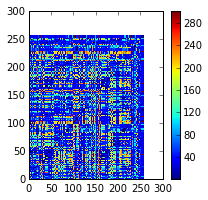

In [379]:
plt.pcolor(distmat+1)
plt.colorbar()

In [416]:
Z = linkage(distmat, 'average')

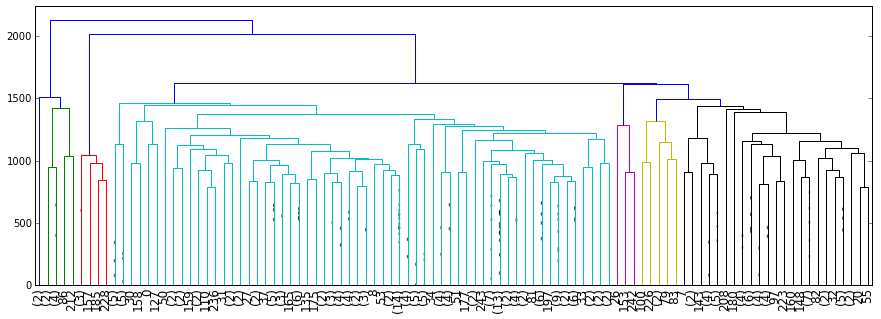

In [417]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=100,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
);

In [418]:
from scipy.cluster.hierarchy import fcluster
max_d = 500
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([ 21, 109, 110,  74,  64, 101, 109, 153,  83,  76,  93, 157, 183,
        65, 112,  57,  67, 158, 113, 157, 188,  66, 111,  85,  58,  71,
       144,  38,  75,  11,  19,  32, 184, 138, 141,  27,  96,  44,  43,
        97,  42,  39,  41,  40,   5,  70,  36,  68,  70,  69,  84,  94,
        25,  82,  26, 189,  74,   9,  15,  15, 182,  15,  91,  16,  92,
        16, 180,  91,  75, 180,  76,  34,  72, 117, 181, 118,  77, 139,
       186, 149, 178, 135, 185, 150, 104, 104,   7, 106,  85, 160, 167,
       168, 164, 156, 156, 168, 165, 169, 167,  31, 145,  31,  10,   4,
        59,  87,  61,  62,  60,  88,  29, 102,   4, 100, 136, 128,  37,
        35, 120, 121, 139, 187, 160,  87,  87,  88, 105,  22, 163,  78,
       100,  48, 163, 151, 103,  55,  79,  90, 155, 175, 105,  62, 132,
       159, 103,  49, 105, 155, 176, 105,  85,  62, 131, 142,  45, 103,
        52,  14,  20,  33, 177, 137, 126,  28, 128,  54,  50, 133,  51,
       134,  53,   6, 129,  46, 130,  56, 115,  95,  23,  81, 19

1005 293 193


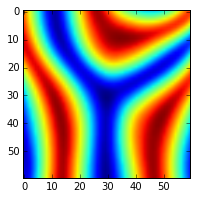

In [434]:
cluster = 12

plt.rcParams['figure.figsize'] = (3.0, 3.0)

for i in np.argwhere(clusters==cluster):
    time = features[i,0][0]
    x = features[i,1][0]
    y = features[i,2][0]
    
    print time, x, y
    bmp_match = bmps[time][(y - radius):(y + radius), (x - radius):(x + radius)]
    plt.imshow(bmp_match);
    
    plt.show();